In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import anndata as an
import scanpy as sc 
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import numpy as np

In [2]:
files = ["data/" + f for f in os.listdir("./data") if f.endswith('.npy')]

datasets = []

for file in files:
    data = np.load(file)
    datasets.append(data)
    
data = np.concatenate(datasets, axis=0)

class EphysDataset(Dataset):
    def __init__(self, data, normalize=True):
        self.data = data
        self.normalize = normalize
        
    def __getitem__(self, idx):
        sample = torch.as_tensor(self.data[idx, ...]).float()
        
        if self.normalize:
            sample = (sample - sample.mean()) / sample.std()

        sample = sample.unsqueeze(0)
        
        return sample 
    
    def __len__(self):
        return len(self.data)

In [3]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class VAEModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv1d(1, 32, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),
            
                nn.Conv1d(32, 32, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),

                nn.Conv1d(32, 64, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),
                
                nn.BatchNorm1d(64),
            
                nn.Conv1d(64, 32, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),

                nn.Conv1d(32, 1, stride=2, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),
            
                Reshape(-1, 25),
        )

        self.z_mean = nn.Linear(25, 10)
        self.z_log_var = nn.Linear(25, 10)

        self.decoder = nn.Sequential(
            nn.Linear(10, 25),
            
            Reshape(-1, 1, 25),
            nn.ConvTranspose1d(1, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),
        
            nn.BatchNorm1d(64),
            
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),

            nn.ConvTranspose1d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),

            nn.Sigmoid(),
        )

    def reparametrize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparametrize(z_mean, z_log_var)
        decoded = self.decoder(encoded)

        return encoded, z_mean, z_log_var, decoded

In [4]:
base_model = VAEModel()

In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import wandb

class VAE(pl.LightningModule):
    def __init__(self, model, alpha_max):
        super().__init__()
        self.model = model
        self.alpha_max = alpha_max
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        if batch_idx == 0:
            print(f'Epoch {self.current_epoch}')

        data = batch
        enc, zmean, zlogvar, dec = self.model(data)
        mse_loss = F.mse_loss(data, dec)
        
        kl_loss = -0.5 * torch.sum(1 + zlogvar - zmean.pow(2) - torch.exp(zlogvar), axis=1)
        
        total_epochs = self.trainer.max_epochs
        current_epoch = self.current_epoch

        if current_epoch % 2 == 1:
            alpha = min(current_epoch / total_epochs, self.alpha_max)
        else:
            alpha = self.alpha_max
            
        loss = mse_loss + alpha * kl_loss.mean()

        self.log('train_loss', loss)
        self.log('train_mse_loss', mse_loss)
        self.log('train_kl_loss', kl_loss.mean())

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01, weight_decay=0.01)


In [6]:
traindataset = EphysDataset(data)
train_loader = DataLoader(traindataset, batch_size=64, num_workers=0)

In [7]:
next(iter(train_loader)).shape

torch.Size([64, 1, 50])

In [8]:
model = VAE(base_model, alpha_max=0.5)

wandb_logger = pl.loggers.WandbLogger(reinit=True)
trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, track_grad_norm=2)
trainer.fit(model, train_loader)

wandb: Currently logged in as: jlehrer1 (mostajo-group). Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | VAEModel | 29.4 K
-----------------------------------
29.4 K    Trainable params
0         Non-trainable params
29.4 K    Total params
0.117     Total estimated model params size (MB)
/Users/julian/miniconda3/envs/benchmarking/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


`Trainer.fit` stopped: `max_epochs=100` reached.


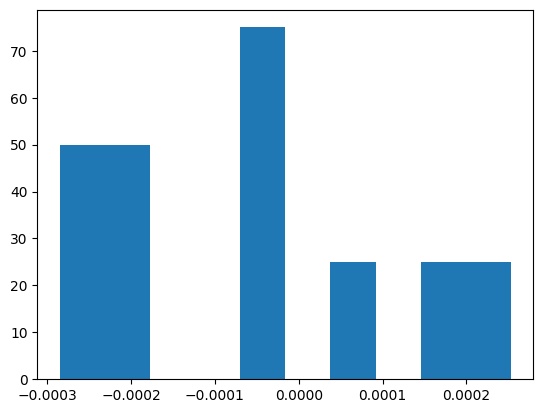

In [9]:
plt.hist(model.model.z_log_var.weight.detach().numpy().flatten());
plt.savefig('test.png')
plt.show()

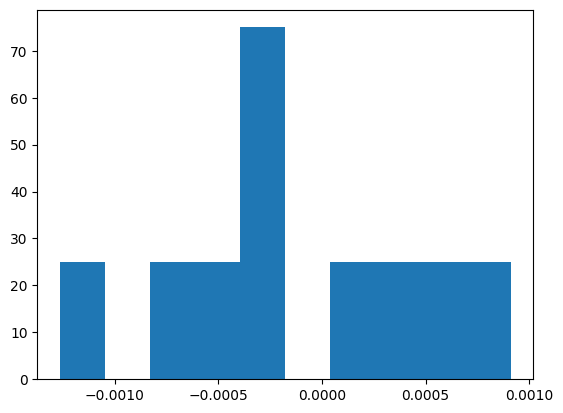

In [10]:
plt.hist(model.model.z_mean.weight.detach().numpy().flatten());

In [11]:
def plot_waveforms(tensor, title):
    B, C = tensor.shape
    plt.figure(figsize=(10, 5))
    for i in range(B):
        plt.subplot(B, 1, i+1)
        plt.plot(tensor[i].numpy())
    plt.tight_layout()
    plt.savefig(title + '.png')
    plt.show()

In [12]:
sample = next(iter(train_loader))

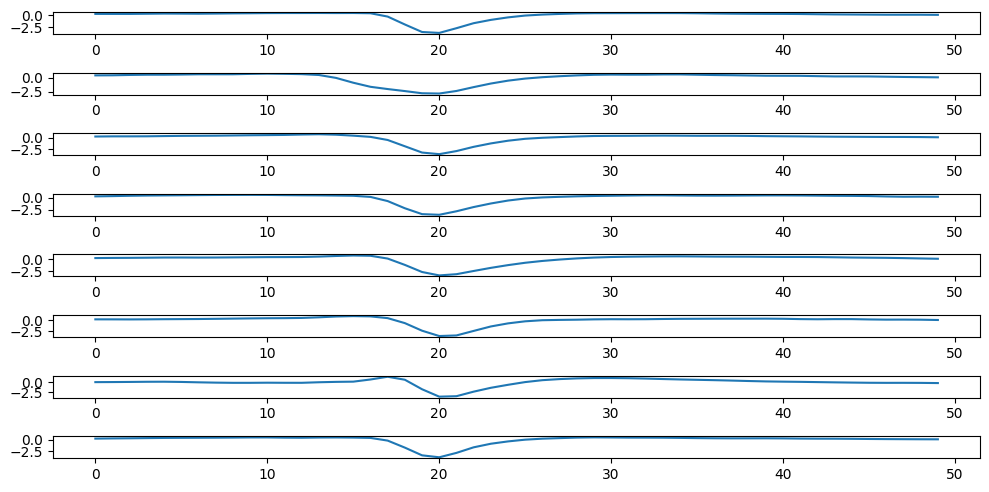

In [21]:
plot_waveforms(sample.squeeze(1).detach()[0:8], 'train sample')

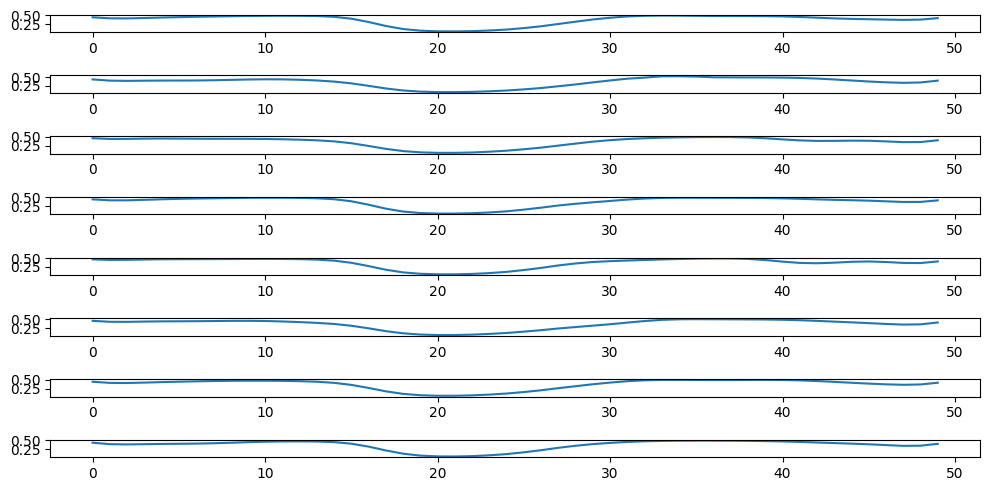

In [22]:
plot_waveforms(model(sample)[-1].squeeze(1).detach()[0:8], 'reconstructed train sample')

In [23]:
trained_model = model.model

generated = trained_model.decoder(torch.randn(8, 10)).detach().squeeze(1)

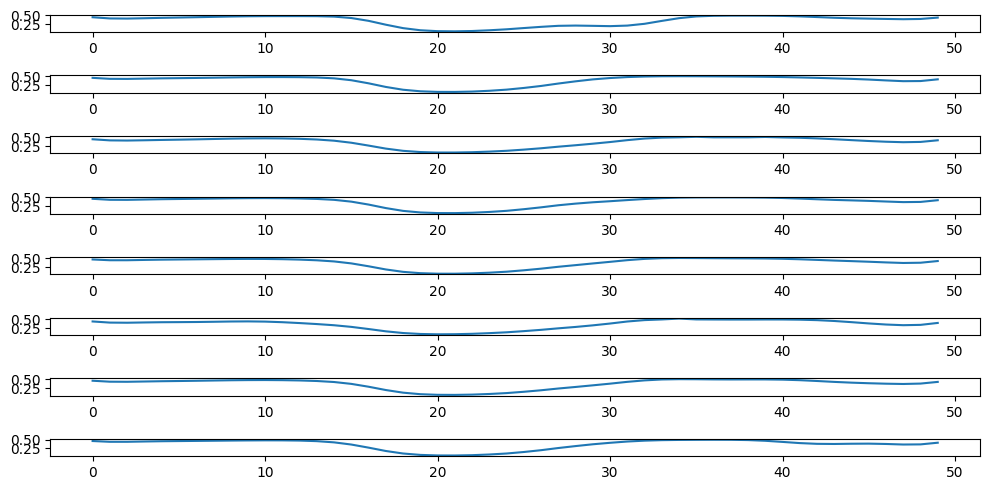

In [24]:
plot_waveforms(generated, 'generated samples')

In [16]:
generated.shape

torch.Size([8, 50])

In [17]:
model(torch.randn(8, 1, 500))

(tensor([[ 1.4770e+00, -2.7302e-01,  1.8579e+00, -1.3878e+00, -4.2547e-01,
           7.5418e-01,  7.3421e-01,  9.5646e-01, -9.2844e-01, -6.3067e-01],
         [ 1.2167e+00,  2.7539e-01,  2.7652e-01, -6.5540e-01, -1.3213e+00,
          -1.8139e+00,  2.4352e-01, -6.9549e-01, -7.4860e-01, -9.5685e-01],
         [ 9.1143e-01, -7.9175e-01,  4.9509e-01, -2.1519e+00,  9.6296e-01,
           1.2278e-01, -7.3531e-01, -1.4390e-01,  8.3137e-01,  7.2780e-02],
         [ 3.5288e-01,  3.0181e-01, -1.1430e+00,  7.4185e-01,  2.8863e-01,
           5.9322e-01, -7.7630e-01,  3.8697e-01,  2.7056e+00,  8.1426e-01],
         [ 8.1971e-01, -5.3369e-02,  4.7817e-01,  6.1214e-01, -8.8042e-02,
          -5.3360e-01, -3.8187e-01, -1.5147e-01,  5.2102e-04,  1.9957e-01],
         [-1.4712e+00,  1.7056e-01,  8.5431e-01,  1.3369e-02, -6.5189e-01,
          -2.8629e-01, -1.1299e+00,  9.2490e-01,  3.7183e-01,  2.3112e-01],
         [ 6.5379e-01,  7.2171e-01,  8.0554e-01,  3.7179e-01,  1.3262e-01,
          -3.9192e-